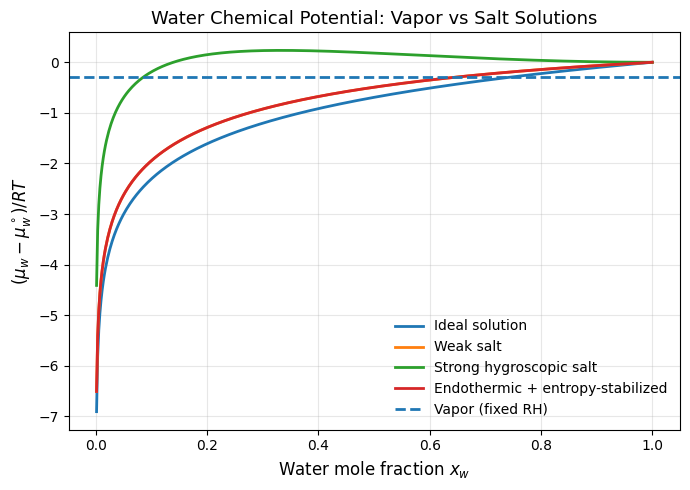

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Parameters
# -------------------------
R = 8.314      # J/mol/K
T = 298.15     # K
RT = R * T

RH = 0.75      # relative humidity (sets vapor chemical potential)

# Composition grid (avoid x_w = 0)
xw = np.linspace(1e-3, 1.0, 500)

# -------------------------
# Chemical potentials
# -------------------------

# Vapor (flat line)
mu_vapor = RT * np.log(RH)

# Ideal solution
mu_ideal = RT * np.log(xw)

# Weakly non-ideal salt
A = 0.4
ln_gamma_weak = A * (1 - xw)
mu_weak = RT * (np.log(xw) + ln_gamma_weak)

# Strongly hygroscopic salt
A = 1.0
B = 1.5
ln_gamma_strong = A * (1 - xw) + B * (1 - xw)**2
mu_strong = RT * (np.log(xw) + ln_gamma_strong)

# Endothermic but entropy-stabilized salt
A = 1.2      # enthalpic penalty
C = 0.8      # entropic stabilization
ln_gamma_entropy = A * (1 - xw) - C * (1 - xw)
mu_entropy = RT * (np.log(xw) + ln_gamma_entropy)

# -------------------------
# Plot
# -------------------------
plt.figure(figsize=(7,5))

plt.plot(xw, mu_ideal/RT, label="Ideal solution", linewidth=2)
plt.plot(xw, mu_weak/RT, label="Weak salt", linewidth=2)
plt.plot(xw, mu_strong/RT, label="Strong hygroscopic salt", linewidth=2)
plt.plot(xw, mu_entropy/RT, label="Endothermic + entropy-stabilized", linewidth=2)

plt.axhline(mu_vapor/RT, linestyle="--", linewidth=2, label="Vapor (fixed RH)")

plt.xlabel(r"Water mole fraction $x_w$", fontsize=12)
plt.ylabel(r"$(\mu_w - \mu_w^\circ)/RT$", fontsize=12)
plt.title("Water Chemical Potential: Vapor vs Salt Solutions", fontsize=13)

plt.legend(frameon=False)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


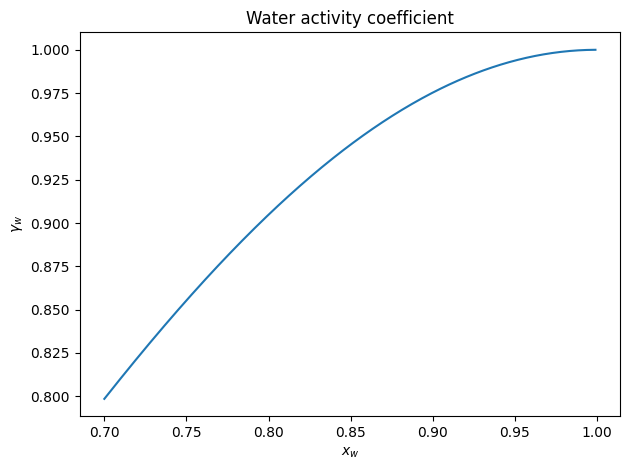

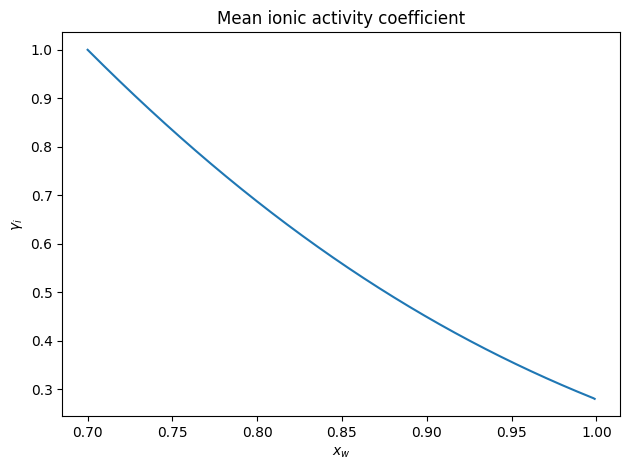

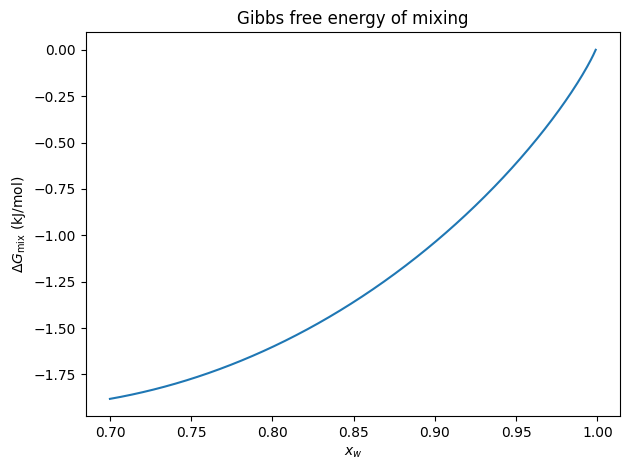

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Constants (with units)
# ============================================================
R = 8.314462618e-3   # kJ / (mol K)
T = 298.15          # K
RT = R * T          # kJ / mol

# ============================================================
# Composition grid
# ============================================================
xw = np.linspace(0.70, 0.999, 400)
xi = 1.0 - xw

# ============================================================
# 1. Prescribed water activity coefficient γ_w(x_w)
# ============================================================
# Smooth, monotonic, non-ideal but reasonable
gamma_w = np.exp(-2.5 * (1.0 - xw)**2)

# ============================================================
# 2. Use Gibbs–Duhem to infer mean ionic activity coefficient
#    xw dlnγw + xi dlnγi = 0
# ============================================================
ln_gamma_w = np.log(gamma_w)
dln_gamma_w_dxw = np.gradient(ln_gamma_w, xw)

dln_gamma_i_dxw = -(xw / xi) * dln_gamma_w_dxw

ln_gamma_i = np.zeros_like(xw)
for k in range(1, len(xw)):
    ln_gamma_i[k] = (
        ln_gamma_i[k-1]
        + dln_gamma_i_dxw[k] * (xw[k] - xw[k-1])
    )

gamma_i = np.exp(ln_gamma_i)

# ============================================================
# 3. Gibbs free energy of mixing (kJ/mol of solution)
# ============================================================
Gmix = RT * (
    xw * np.log(xw * gamma_w)
    + xi * np.log(xi * gamma_i)
)

# Reference zero at pure water
Gmix -= Gmix[-1]

# ============================================================
# 4. Plots (included but not executed here)
# ============================================================

# Water activity coefficient
plt.figure()
plt.plot(xw, gamma_w)
plt.xlabel(r"$x_w$")
plt.ylabel(r"$\gamma_w$")
plt.title("Water activity coefficient")
plt.tight_layout()

# Mean ionic activity coefficient
plt.figure()
plt.plot(xw, gamma_i)
plt.xlabel(r"$x_w$")
plt.ylabel(r"$\gamma_i$")
plt.title("Mean ionic activity coefficient")
plt.tight_layout()

# Gibbs free energy of mixing
plt.figure()
plt.plot(xw, Gmix)
plt.xlabel(r"$x_w$")
plt.ylabel(r"$\Delta G_{\mathrm{mix}}\ \mathrm{(kJ/mol)}$")
plt.title("Gibbs free energy of mixing")
plt.tight_layout()

# Uncomment to display plots
# plt.show()


converged SCF energy = -713.814719350089
converged SCF energy = -717.738434340068


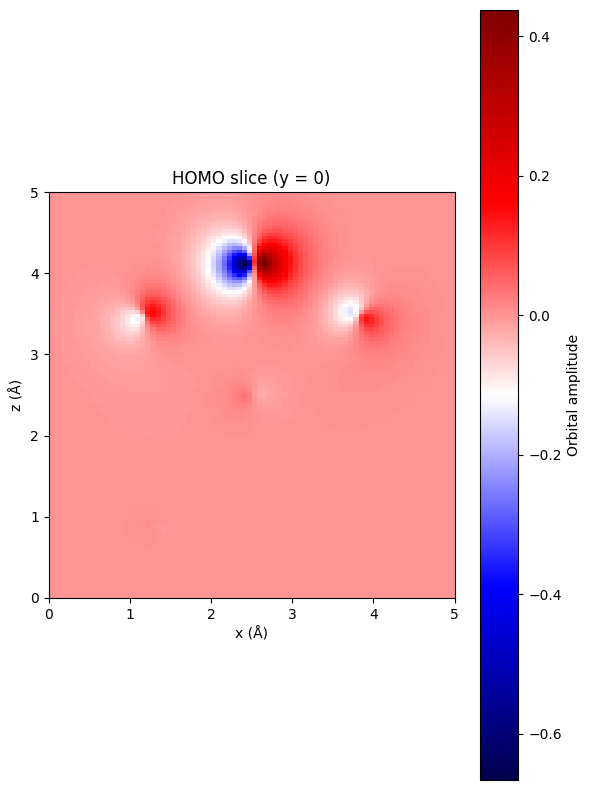

In [ ]:
!pip install pyscf
import numpy as np
from pyscf import gto, scf, dft, tools
import matplotlib.pyplot as plt
from pyscf.tools import cubegen

# ----------------------------
# 1. Molecule
# ----------------------------
mol = gto.Mole()
mol.atom = """
Li   0.000   0.000  -3.000
F    0.000   0.000   0.000

# ==========================
# Li+ hydration (O toward Li)
# ==========================

O    2.100   0.000  -3.000
H    2.857   0.757  -3.000
H    2.857  -0.757  -3.000

O   -2.100   0.000  -3.000
H   -2.857   0.757  -3.000
H   -2.857  -0.757  -3.000

O    0.000   2.100  -3.000
H    0.757   2.857  -3.000
H   -0.757   2.857  -3.000

O    0.000  -2.100  -3.000
H    0.757  -2.857  -3.000
H   -0.757  -2.857  -3.000

# ==========================
# F− hydration (H toward F)
# ==========================

O    0.000   0.000   3.000
H    0.586   0.757   2.100
H   -0.586  -0.757   2.100

O    2.400   0.000   1.800
H    1.814   0.757   0.900
H    1.814  -0.757   0.900

O   -2.400   0.000   1.800
H   -1.814   0.757   0.900
H   -1.814  -0.757   0.900

O    0.000   2.400   1.800
H    0.757   1.814   0.900
H   -0.757   1.814   0.900
"""

mol.basis = "def2-SVP"
mol.unit = "Angstrom"
mol.charge = 0
mol.spin = 0
mol.build()

# ----------------------------
# 2. Hartree–Fock (robust)
# ----------------------------
mf = scf.RHF(mol)
mf.max_cycle = 100
mf.diis_space = 8
mf.chkfile = "hf.chk"
mf.kernel()

# ----------------------------
# 3. Restart with DFT
# ----------------------------
mf = dft.RKS(mol)
mf.xc = "B3LYP"
mf.init_guess = "chkfile"
mf.chkfile = "hf.chk"
mf.max_cycle = 100
mf.damp = 0.3
mf.kernel()

assert mf.converged, "SCF still not converged"

# ----------------------------
# 4. Orbital indices
# ----------------------------
occ = mf.mo_occ
homo = np.where(occ > 0)[0][-1]
lumo = homo + 1

# ----------------------------
# 5. Cube grid (Bohr!)
# ----------------------------
bohr = 1.889726
origin = np.array([0, 0, 0]) * bohr
extent = np.array([8, 8, 12]) * bohr
nx, ny, nz = 80, 80, 120

cube = cubegen.Cube(mol, nx=nx, ny=ny, nz=nz)

cube.box = np.array([
    [-4*bohr, -4*bohr, -6*bohr],
    [ 4*bohr,  4*bohr,  6*bohr]
])

# Write orbitals (VERSION-SAFE)
cubegen.orbital(mol, "HOMO2.cube", mf.mo_coeff[:, homo])
cubegen.orbital(mol, "LUMO2.cube", mf.mo_coeff[:, lumo])

# # Optional density
cubegen.density(mol, "density.cube", mf.make_rdm1())

# print("Cube files written successfully.")

# # Slice HOMO in the x–z plane at y=0
# orb = tools.cubegen.orbital(
#     mol, None, mf.mo_coeff[:, homo],
#     nx=nx, ny=ny, nz=nz
# )

# # orb has shape (nx, ny, nz)
# slice_y = ny // 2
# orb_slice = orb[:, slice_y, :]

# box = ((-4, -4, -6), (4, 4, 6))  # spatial extent (Å)

# plt.figure(figsize=(6, 8))
# plt.imshow(
#     orb_slice.T,
#     origin="lower",
#     extent=[box[0][0], box[1][0], box[0][2], box[1][2]],
#     cmap="seismic"
# )
# plt.colorbar(label="Orbital amplitude")
# plt.xlabel("x (Å)")
# plt.ylabel("z (Å)")
# plt.title("HOMO slice (y = 0)")
# plt.tight_layout()
# plt.show()
# ----------------------------
# Slice and Plot without File I/O
# ----------------------------

# 1. Create the Cube object (which generates the 3D grid)
cube = cubegen.Cube(mol, nx=nx, ny=ny, nz=nz)

# 2. Extract grid coordinates (N_points, 3)
coords = cube.get_coords()

# 3. Evaluate Atomic Orbitals (AOs) on these grid points
ao = mol.eval_gto('GTOval', coords)

# 4. Compute HOMO on the grid (dot product of AOs and MO coefficients)
# Then reshape from 1D to the 3D grid dimensions
orb = np.dot(ao, mf.mo_coeff[:, homo]).reshape(cube.nx, cube.ny, cube.nz)

# 5. Slice in the x–z plane at the middle y-index
slice_y = cube.ny // 2
orb_slice = orb[:, slice_y, :]

# 6. Extract spatial extents in Angstroms for the plot axes
bohr = 1.889726
x_min, y_min, z_min = 0,0,0
x_max, y_max, z_max = 5,5,5
plot_extent = [x_min, x_max, z_min, z_max]

# 7. Plotting
plt.figure(figsize=(6, 8))
plt.imshow(
    orb_slice.T, # Transposed so X is horizontal, Z is vertical
    origin="lower",
    extent=plot_extent,
    cmap="seismic"
)

# Optional: Add a colormap limit so the zero-nodes are strictly white
# v_max = np.max(np.abs(orb_slice))
# plt.clim(-v_max, v_max)

plt.colorbar(label="Orbital amplitude")
plt.xlabel("x (Å)")
plt.ylabel("z (Å)")
plt.title("HOMO slice (y = 0)")
plt.tight_layout()
plt.show()

In [ ]:
# !pip install scipy
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.integrate import quad, cumulative_trapezoid

# # =========================
# # Physical constants (SI)
# # =========================
# kB = 1.380649e-23
# T = 298.15
# e = 1.602176634e-19
# eps0 = 8.8541878128e-12
# NA = 6.02214076e23
# eps_r = 78.4  # water at 25 C
# beta = 1 / (kB * T)

# # =========================
# # LiCl parameters (FIRST PRINCIPLES)
# # =========================
# z = 1
# r_Li = 0.76e-10     # m (Shannon radius)
# r_Cl = 1.81e-10     # m
# r_contact = r_Li + r_Cl

# # Debye–Hückel constant A (molality scale)
# A_DH = 0.509  # water, 25 C

# Mw = 0.018015  # kg/mol

# # =========================
# # Bjerrum pairing constant
# # =========================
# def bjerrum_constant():
#     def integrand(r):
#         U = -(z**2 * e**2) / (4*np.pi*eps0*eps_r*r)
#         return 4*np.pi*r**2 * np.exp(-beta*U)

#     r_max = 1.5e-9  # Bjerrum cutoff (~15 Å)
#     val, _ = quad(integrand, r_contact, r_max, limit=200)
#     return NA * val  # m^3/mol

# K_pair = bjerrum_constant()  # association constant

# # =========================
# # Speciation model
# # =========================
# def free_ion_fraction(m):
#     """
#     Solve: m_free^2 * K = m_pair
#     m = m_free + m_pair
#     """
#     # Quadratic: K m_f^2 + m_f - m = 0
#     a = K_pair
#     b = 1.0
#     c = -m
#     mf = (-b + np.sqrt(b*b - 4*a*c)) / (2*a)
#     return mf / m

# # =========================
# # Mean ionic activity coefficient
# # =========================
# def gamma_pm(m):
#     f_free = free_ion_fraction(m)
#     m_eff = m * f_free
#     return np.exp(-A_DH * np.sqrt(m_eff))

# # =========================
# # Water activity from Gibbs–Duhem
# # =========================
# def water_activity(m_vals):
#     ln_gamma = np.log([gamma_pm(m) for m in m_vals])
#     ln_mgamma = np.log(m_vals) + ln_gamma
#     d_lnmgamma_dm = np.gradient(ln_mgamma, m_vals)
#     integrand = -2 * Mw * m_vals * d_lnmgamma_dm
#     ln_aw = cumulative_trapezoid(integrand, m_vals, initial=0)
#     return np.exp(ln_aw)

# # =========================
# # Convert x_w → molality
# # =========================
# def molality_from_xw(xw):
#     # 1 kg water basis
#     nw = 1000 / 18.015
#     ns = nw * (1 - xw) / xw
#     return ns

# # =========================
# # Main calculation
# # =========================
# xw = np.linspace(0.80, 0.999, 80)
# m = molality_from_xw(xw)

# aw = water_activity(m)
# gamma_w = aw / xw

# # =========================
# # Plot
# # =========================
# plt.figure(figsize=(6,4))
# plt.plot(xw, gamma_w, 'o-', label=r'$\gamma_w$ (LiCl)')
# plt.xlabel('Water mole fraction $x_w$')
# plt.ylabel('Water activity coefficient $\gamma_w$')
# plt.title('LiCl: Water Activity Coefficient (Minimal First-Principles Model)')
# plt.legend()
# plt.tight_layout()
# plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Constants for Aqueous 1:1 Electrolyte at 25 C ---
MW_WATER = 0.018015  # kg/mol
NU = 2.0             # Stoichiometric coefficient for 1:1 salt (e.g., LiCl, NaCl)
A_DH = 1.17          # Debye-Huckel constant for ln(gamma) in water at 25 C (kg^0.5 / mol^0.5)

def calc_debye_huckel_water_activity(xw):
    """
    Calculates water activity and activity coefficient using the
    Debye-Huckel limiting law integrated via Gibbs-Duhem.
    """
    # 1. Convert water mole fraction (xw) to molality (m)
    # xw = (1/Mw) / (1/Mw + nu * m)  =>  m = (1 - xw) / (nu * Mw * xw)
    m = (1.0 - xw) / (NU * MW_WATER * xw)

    # 2. Calculate natural log of water activity (ln_aw) from derived equation
    # ln(a_w) = -nu * Mw * (m - (A/3) * m^(3/2))
    ln_aw = -NU * MW_WATER * (m - (A_DH / 3.0) * m**(1.5))

    # 3. Calculate activity coefficient (gamma_w = aw / xw)
    ln_xw = np.log(xw)
    ln_gamma_w = ln_aw - ln_xw

    return np.exp(ln_gamma_w), np.exp(ln_aw), m

def main():
    # Generate water mole fractions from 0.9 to 0.999
    # (Avoid exact 1.0 to prevent divide-by-zero in edge cases)
    xw_array = np.linspace(0.90, 0.999, 500)

    gamma_w_array = []
    aw_array = []
    m_array = []

    for xw in xw_array:
        gw, aw, m = calc_debye_huckel_water_activity(xw)
        gamma_w_array.append(gw)
        aw_array.append(aw)
        m_array.append(m)

    gamma_w_array = np.array(gamma_w_array)

    # --- Plotting ---
    fig, ax1 = plt.subplots(figsize=(8, 5))

    ax1.plot(xw_array, gamma_w_array, 'b-', lw=2.5, label='Debye-Hückel Limit')
    ax1.plot([0.9, 1.0], [1.0, 1.0], 'k--', lw=1.5, label='Ideal Solution (gamma = 1)')

    ax1.set_xlabel('Water Mole Fraction ($x_w$)', fontsize=12)
    ax1.set_ylabel('Water Activity Coefficient ($\gamma_w$)', fontsize=12, color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_xlim(0.9, 1.0)

    # Add a secondary axis to show the molality scale for context
    ax2 = ax1.twiny()
    m_ticks = np.array([0.1, 1.0, 2.0, 4.0, 6.0])
    # Convert chosen molalities back to xw for the tick placement
    xw_ticks = 1.0 / (1.0 + NU * m_ticks * MW_WATER)

    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(xw_ticks)
    ax2.set_xticklabels([f"{m} m" for m in m_ticks])
    ax2.set_xlabel('Salt Molality (mol/kg)', fontsize=10, color='gray')

    plt.title('Debye-Hückel Water Activity Coefficient via Gibbs-Duhem', pad=15)
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

<>:61: SyntaxWarning: invalid escape sequence '\g'
<>:64: SyntaxWarning: invalid escape sequence '\g'
<>:61: SyntaxWarning: invalid escape sequence '\g'
<>:64: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-2174568808.py:61: SyntaxWarning: invalid escape sequence '\g'
  ax1.plot([0.9, 1.0], [1.0, 1.0], 'k:', lw=1.5, label='Ideal Solution ($\gamma_w = 1$)')
/tmp/ipython-input-2174568808.py:64: SyntaxWarning: invalid escape sequence '\g'
  ax1.set_ylabel('Water Activity Coefficient ($\gamma_w$)', fontsize=12)


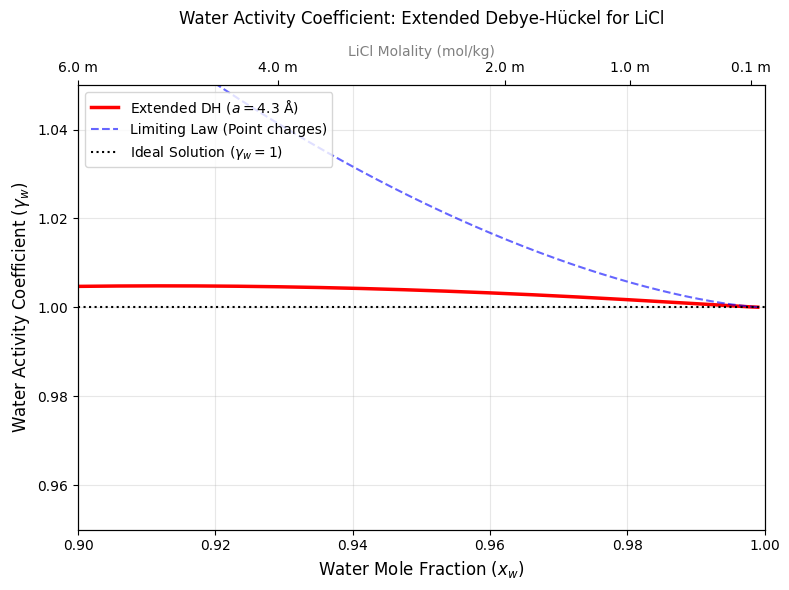

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Constants for LiCl in Water at 25 C ---
MW_WATER = 0.018015  # kg/mol
NU = 2.0             # Stoichiometric coefficient for LiCl
A_DH = 1.17          # Debye-Huckel constant A (kg^0.5 / mol^0.5)
B_DH = 0.328         # Debye-Huckel constant B (1 / Angstrom)
A_ION = 4.3          # Distance of closest approach for LiCl in Angstroms

def calc_extended_dh_water_activity(xw):
    """
    Calculates water activity coefficient using the Extended Debye-Huckel
    equation integrated via the Gibbs-Duhem relation (Bjerrum's method).
    """
    # 1. Convert water mole fraction to molality
    m = (1.0 - xw) / (NU * MW_WATER * xw)

    # 2. Calculate the volume-correction term (sigma)
    b = B_DH * A_ION
    x = b * np.sqrt(m)

    # sigma(x) function from the exact integration
    sigma = (3.0 / x**3) * (1.0 + x - 1.0/(1.0 + x) - 2.0 * np.log(1.0 + x))

    # 3. Calculate osmotic coefficient (phi)
    phi = 1.0 - (A_DH / 3.0) * np.sqrt(m) * sigma

    # 4. Calculate activity coefficient (gamma_w = aw / xw)
    ln_aw = -NU * MW_WATER * m * phi
    ln_xw = np.log(xw)
    ln_gamma_w = ln_aw - ln_xw

    return np.exp(ln_gamma_w)

def calc_limiting_dh_water_activity(xw):
    """Previous limiting law for comparison."""
    m = (1.0 - xw) / (NU * MW_WATER * xw)
    ln_aw = -NU * MW_WATER * (m - (A_DH / 3.0) * m**(1.5))
    return np.exp(ln_aw - np.log(xw))

def main():
    # Mole fraction range (avoid exactly 1.0 to prevent divide-by-zero in sigma)
    xw_array = np.linspace(0.90, 0.999, 500)

    gamma_extended = []
    gamma_limiting = []
    m_array = []

    for xw in xw_array:
        gamma_extended.append(calc_extended_dh_water_activity(xw))
        gamma_limiting.append(calc_limiting_dh_water_activity(xw))
        m = (1.0 - xw) / (NU * MW_WATER * xw)
        m_array.append(m)

    # --- Plotting ---
    fig, ax1 = plt.subplots(figsize=(8, 6))

    ax1.plot(xw_array, gamma_extended, 'r-', lw=2.5, label=f'Extended DH ($a = {A_ION}$ Å)')
    ax1.plot(xw_array, gamma_limiting, 'b--', lw=1.5, alpha=0.6, label='Limiting Law (Point charges)')
    ax1.plot([0.9, 1.0], [1.0, 1.0], 'k:', lw=1.5, label='Ideal Solution ($\gamma_w = 1$)')

    ax1.set_xlabel('Water Mole Fraction ($x_w$)', fontsize=12)
    ax1.set_ylabel('Water Activity Coefficient ($\gamma_w$)', fontsize=12)
    ax1.set_xlim(0.9, 1.0)

    # Secondary axis for molality
    ax2 = ax1.twiny()
    m_ticks = np.array([0.1, 1.0, 2.0, 4.0, 6.0])
    xw_ticks = 1.0 / (1.0 + NU * m_ticks * MW_WATER)

    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(xw_ticks)
    ax2.set_xticklabels([f"{m} m" for m in m_ticks])
    ax2.set_xlabel('LiCl Molality (mol/kg)', fontsize=10, color='gray')

    plt.title('Water Activity Coefficient: Extended Debye-Hückel for LiCl', pad=15)
    plt.ylim(0.95, 1.05)
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

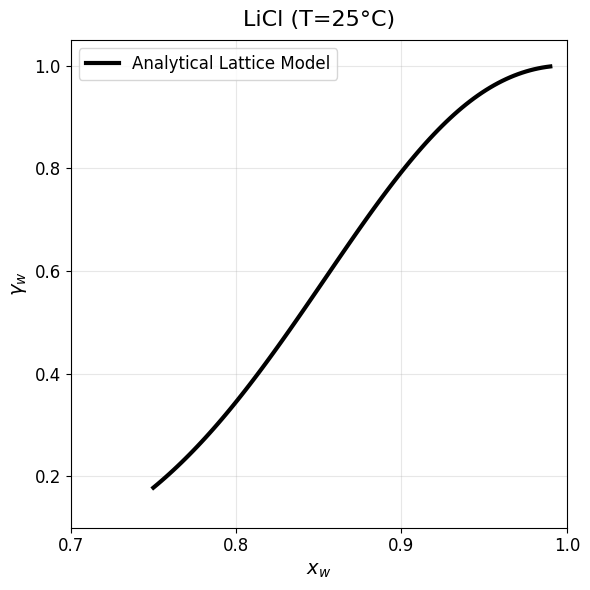

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Thermodynamics Constants ---
R_GAS = 8.314
T_K = 298.15
RT = R_GAS * T_K

# --- Model Parameters ---
# 1. Debye-Huckel Term (Small positive correction at high water)
C_DH = 0.5

# 2. Baseline Regular Solution Parameter (Large and negative)
ALPHA_BASE = -55_000  # J/mol

# 3. Diminishing Returns Hydration Boost (Extra negative energy at low water)
ALPHA_HYD = -25_000   # J/mol
K_DECAY = 0.15        # Controls how fast the "extra" benefit drops off

def calc_gamma_w_analytical(xw):
    """
    Calculates gamma_w using the perturbed regular solution model.
    """
    # Prevent divide by zero at boundaries
    xw = np.clip(xw, 0.0001, 0.9999)
    xs = 1.0 - xw
    ratio_w_s = xw / xs

    # 1. Debye-Huckel correction (positive, small)
    ln_gamma_dh = C_DH * (xs**1.5)

    # 2. Effective Alpha (gets more negative as water decreases)
    alpha_eff = ALPHA_BASE + ALPHA_HYD * np.exp(-K_DECAY * ratio_w_s)

    # 3. Regular Solution term
    ln_gamma_rs = (alpha_eff / RT) * (xs**2)

    # Total activity coefficient
    ln_gamma_total = ln_gamma_dh + ln_gamma_rs

    return np.exp(ln_gamma_total)

def main():
    # Plot range matching the target image
    xw_vec = np.linspace(0.75, 0.99, 100)
    gamma_w_vec = [calc_gamma_w_analytical(x) for x in xw_vec]

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(6, 6))

    # Plot the analytical model
    ax.plot(xw_vec, gamma_w_vec, color='black', linewidth=3, label='Analytical Lattice Model')

    # Formatting to match the provided target image
    ax.set_xlabel(r'$x_w$', fontsize=14)
    ax.set_ylabel(r'$\gamma_w$', fontsize=14)
    ax.set_title(r'LiCl (T=25°C)', fontsize=16, pad=10)

    # Set axis limits exactly like the target image
    ax.set_xlim(0.7, 1.0)
    ax.set_ylim(0.1, 1.05)

    # Ticks and Grid
    ax.set_xticks([0.7, 0.8, 0.9, 1.0])
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True, alpha=0.3)

    ax.legend(loc='upper left', fontsize=12)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

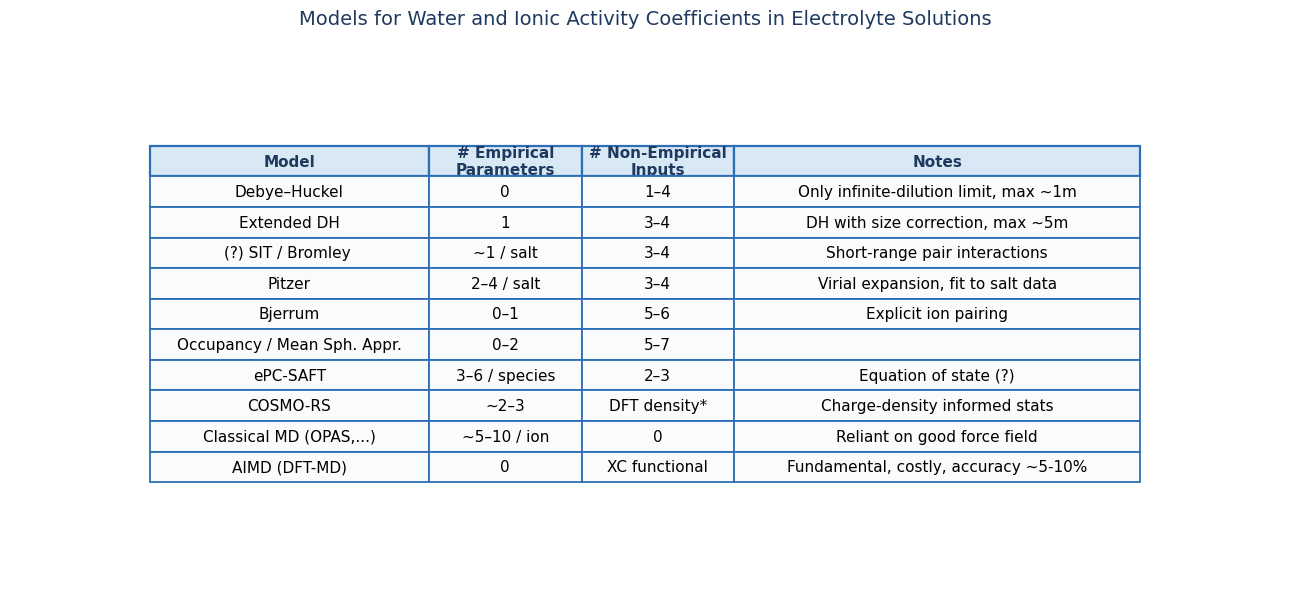

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# ----------------------------
# Table data
# ----------------------------
data = [
    ["Debye–Huckel", "0", "1–4", "Only infinite-dilution limit, max ~1m"],
    ["Extended DH", "1", "3–4", "DH with size correction, max ~5m"],
    ["(?) SIT / Bromley ", "~1 / salt", "3–4", "Short-range pair interactions"],
    ["Pitzer", "2–4 / salt", "3–4", "Virial expansion, fit to salt data"],
    ["Bjerrum", "0–1", "5–6", "Explicit ion pairing"],
    ["Occupancy / Mean Sph. Appr.", "0–2", "5–7", " "],
    ["ePC-SAFT", "3–6 / species", "2–3", "Equation of state (?)"],
    ["COSMO-RS", "~2–3", "DFT density*", "Charge-density informed stats"],
    ["Classical MD (OPAS,...)", "~5–10 / ion", "0", "Reliant on good force field"],
    ["AIMD (DFT-MD)", "0", "XC functional", "Fundamental, costly, accuracy ~5-10%"],
]

columns = [
    "Model",
    "# Empirical\nParameters",
    "# Non-Empirical\nInputs",
    "Notes"
]

df = pd.DataFrame(data, columns=columns)

# ----------------------------
# Figure
# ----------------------------
fig, ax = plt.subplots(figsize=(13, 6))
ax.axis("off")

# Column width ratios (middle columns ~50% thinner)
col_widths = [0.22, 0.12, 0.12, 0.32]

table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    colWidths=col_widths,
    cellLoc="center",
    loc="center"
)

# ----------------------------
# Styling
# ----------------------------
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 1.6)

header_color = "#D9E8F5"
edge_color = "#2C6FB7"
body_bg = "#F9FBFD"

for (row, col), cell in table.get_celld().items():
    cell.set_edgecolor(edge_color)
    cell.set_linewidth(1.3)

    if row == 0:
        cell.set_facecolor(header_color)
        cell.set_text_props(weight="bold", color="#1F3A5F")
        cell.set_linewidth(1.6)
    else:
        cell.set_facecolor(body_bg)

# ----------------------------
# Title
# ----------------------------
plt.title(
    "Models for Water and Ionic Activity Coefficients in Electrolyte Solutions",
    fontsize=14,
    color="#1F3A5F",
    pad=18
)

plt.tight_layout()
plt.show()


In [ ]:
!pip install pyscf torch dftd3 matplotlib numpy
!pip install tad-dftd3 tad-mctc


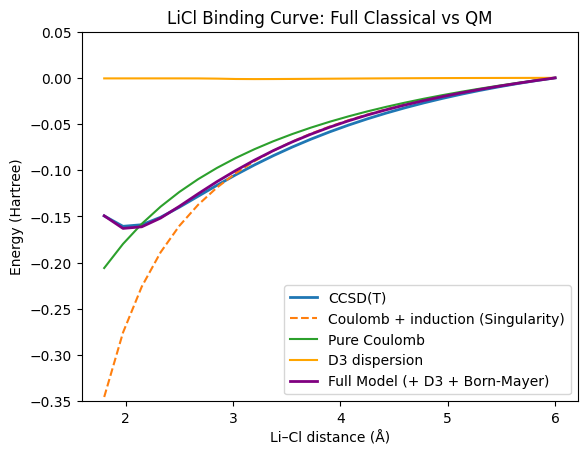

In [ ]:
import numpy as np
import torch
import re
import matplotlib.pyplot as plt
from pyscf import gto, scf, cc
import tad_dftd3 as d3
import tad_mctc as mctc

# -------- Optional log string --------
log_string = """
converged SCF energy = -467.027769147148
E(CCSD) = -467.3750806834676  E_corr = -0.3473115363195223
CCSD(T) correction = -0.00882116082586274
converged SCF energy = -467.039635680179
E(CCSD) = -467.3863422645088  E_corr = -0.3467065843295811
CCSD(T) correction = -0.00883449505116504
converged SCF energy = -467.038259500742
E(CCSD) = -467.3845973409404  E_corr = -0.3463378401986226
CCSD(T) correction = -0.00886178027536189
converged SCF energy = -467.030353615541
E(CCSD) = -467.3764864579739  E_corr = -0.346132842432522
CCSD(T) correction = -0.0088987898387356
converged SCF energy = -467.019504281619
E(CCSD) = -467.3655413453984  E_corr = -0.3460370637794825
CCSD(T) correction = -0.00894111681787177
converged SCF energy = -467.007641525302
E(CCSD) = -467.3536451351818  E_corr = -0.3460036098796332
CCSD(T) correction = -0.00898390277859917
converged SCF energy = -466.995774593828
E(CCSD) = -467.341768715523  E_corr = -0.345994121695084
CCSD(T) correction = -0.00902243082030258
converged SCF energy = -466.984391368005
E(CCSD) = -467.3303723978015  E_corr = -0.3459810297969024
CCSD(T) correction = -0.00905278727120222
converged SCF energy = -466.973699479697
E(CCSD) = -467.3196471068002  E_corr = -0.3459476271031857
CCSD(T) correction = -0.00907225980082671
converged SCF energy = -466.963766650011
E(CCSD) = -467.3096529786789  E_corr = -0.3458863286679373
CCSD(T) correction = -0.00907954052883206
converged SCF energy = -466.954593941603
E(CCSD) = -467.3003898783837  E_corr = -0.3457959367805384
CCSD(T) correction = -0.00907451652478523
converged SCF energy = -466.946151034352
E(CCSD) = -467.2918307487619  E_corr = -0.3456797144099636
CCSD(T) correction = -0.00905816610888108
converged SCF energy = -466.938392868523
E(CCSD) = -467.2839357210244  E_corr = -0.3455428525014952
CCSD(T) correction = -0.00903199319860846
converged SCF energy = -466.931267867075
E(CCSD) = -467.2766600069269  E_corr = -0.345392139851996
CCSD(T) correction = -0.00899818255935043
converged SCF energy = -466.92472256984
E(CCSD) = -467.2699559286059  E_corr = -0.3452333587656438
CCSD(T) correction = -0.00895875844220942
converged SCF energy = -466.918704706576
E(CCSD) = -467.2637770420723  E_corr = -0.3450723354959632
CCSD(T) correction = -0.00891597151944996
converged SCF energy = -466.913165305665
E(CCSD) = -467.2580793192768  E_corr = -0.344914013611383
CCSD(T) correction = -0.00887191824655621
converged SCF energy = -466.90805989434
E(CCSD) = -467.2528220382786  E_corr = -0.3447621439383735
CCSD(T) correction = -0.00882855150704599
converged SCF energy = -466.90334884044
E(CCSD) = -467.2479686763486  E_corr = -0.3446198359090031
CCSD(T) correction = -0.00878780307585701
converged SCF energy = -466.898997037925
E(CCSD) = -467.2434873027769  E_corr = -0.3444902648515201
CCSD(T) correction = -0.00875190771919754
converged SCF energy = -466.894973222888
E(CCSD) = -467.239348689708  E_corr = -0.3443754668195366
CCSD(T) correction = -0.00872309103909349
converged SCF energy = -466.891249184689
E(CCSD) = -467.2355269080706  E_corr = -0.3442777233812252
CCSD(T) correction = -0.00870447931733061
converged SCF energy = -466.887799059355
E(CCSD) = -467.2319979390694  E_corr = -0.3441988797146939
CCSD(T) correction = -0.00870061483978444
converged SCF energy = -466.884598807423
E(CCSD) = -467.228740532236  E_corr = -0.3441417248134034
CCSD(T) correction = -0.00872018614066546
converged SCF energy = -466.881625906236
E(CCSD) = -467.2257349168518  E_corr = -0.3441090106162656
CCSD(T) correction = -0.00877887894708279
"""

r_log = np.linspace(1.8, 6.0, 25)
r_new = np.linspace(6.1, 6.1, 0)
basis = "def2-TZVP"
# ----------------------------

# ---- Polarizabilities (a0^3) ----
alpha_Li = 0.18
alpha_Cl = 37.5
C4 = 0.5 * (alpha_Li + alpha_Cl)

E_cc_log, E_cc_new = [], []

# ---- Parse CCSD(T) ----
if log_string:
    ccsd = [float(x) for x in re.findall(r"E\(CCSD\)\s*=\s*(-?\d+\.\d+)", log_string)]
    triples = [float(x) for x in re.findall(r"CCSD\(T\) correction\s*=\s*(-?\d+\.\d+)", log_string)]
    E_cc_log = np.array([ccsd[i] + triples[i] for i in range(len(triples))])
    r_log = r_log[:len(E_cc_log)]
else:
    r_log = np.array([])

# ---- Compute new CCSD(T) ----
for r in r_new:
    mol = gto.M(atom=f"Li 0 0 0; Cl 0 0 {r}", basis=basis, unit="Angstrom")
    mf = scf.RHF(mol); mf.kernel()
    mycc = cc.CCSD(mf); mycc.kernel()
    E_cc_new.append(mycc.e_tot + float(mycc.ccsd_t()))

E_cc_new = np.array(E_cc_new)

# ---- Merge ----
r_all = np.concatenate([r_log, r_new])
E_cc = np.concatenate([E_cc_log, E_cc_new])

# ---- Polarizable Coulomb + D3 ----
param = {"a1": torch.tensor(0.4289),
         "s8": torch.tensor(0.7875),
         "a2": torch.tensor(4.4407)}
# [ ... keep everything above the "Polarizable Coulomb + D3" section ... ]
# ---- Polarizable Coulomb + D3 + Born-Mayer (physical) ----
A_BM = 57.0      # Hartree (based on ionic radii)
rho_BM = 0.6    # Bohr

E_pure_coul, E_coul, E_disp, E_full_model = [], [], [], []

for r in r_all:
    r_bohr = r / 0.529177

    # Pure Coulomb
    U_coul = -1.0 / r_bohr

    # Induction (charge-induced dipole)
    U_ind = - C4 / (r_bohr**4)

    # Born-Mayer repulsion
    U_rep = A_BM * np.exp(-r_bohr / rho_BM)

    E_pure_coul.append(U_coul)
    E_coul.append(U_coul + U_ind)

    # D3 dispersion
    mol = gto.M(atom=f"Li 0 0 0; Cl 0 0 {r}", basis="def2-SVP", unit="Angstrom")
    numbers = mctc.convert.symbol_to_number(["Li","Cl"])
    pos = torch.tensor(mol.atom_coords(), dtype=torch.float64)
    disp_energy = torch.sum(d3.dftd3(numbers, pos, param)).item()
    E_disp.append(disp_energy)

    # Full classical model
    E_full_model.append(U_coul + U_ind + disp_energy + U_rep)

E_pure_coul = np.array(E_pure_coul)
E_coul = np.array(E_coul)
E_disp = np.array(E_disp)
E_full_model = np.array(E_full_model)

# Normalize
E_cc -= E_cc[-1]
E_pure_coul -= E_pure_coul[-1]
E_coul -= E_coul[-1]
E_disp -= E_disp[-1]
E_full_model -= E_full_model[-1]

# ---- Plot ----
plt.figure()
plt.plot(r_all, E_cc, label="CCSD(T)", linewidth=2)
plt.plot(r_all, E_coul, linestyle='--', label="Coulomb + induction (Singularity)")
plt.plot(r_all, E_pure_coul, label="Pure Coulomb")
plt.plot(r_all, E_disp, label="D3 dispersion", color='orange')
plt.plot(r_all, E_full_model, label="Full Model (+ D3 + Born-Mayer)", color='purple', linewidth=2)

# Restrict y-axis so the singularity doesn't ruin the scale
plt.ylim(-0.35, 0.05)
plt.xlabel("Li–Cl distance (Å)"); plt.ylabel("Energy (Hartree)")
plt.title("LiCl Binding Curve: Full Classical vs QM")
plt.legend(); plt.show()

In [ ]:
import numpy as np
import torch, re
import matplotlib.pyplot as plt
from pyscf import gto, scf, cc, mcscf
from pyscf import mrpt
import tad_dftd3 as d3
import tad_mctc as mctc

# ========= USER OPTIONS =========
method = 2      # 1 = CCSD(T), 2 = CASSCF+NEVPT2
basis = "aug-cc-pVTZ"
r_vals = np.linspace(1.8, 8.0, 20)
# =================================

E_tot = []

for r in r_vals:

    mol = gto.M(atom=f"Li 0 0 0; Cl 0 0 {r}",
                basis=basis,
                unit="Angstrom",
                charge=0, spin=0)

    mf = scf.RHF(mol)
    mf.kernel()

    if method == 1:
        mycc = cc.CCSD(mf)
        mycc.kernel()
        E = mycc.e_tot + float(mycc.ccsd_t())

    elif method == 2:
        # Minimal active space for LiCl ionic bonding
        # (Li 2s, Cl 3p orbitals ~ 4 electrons in 4 orbitals)
        mc = mcscf.CASSCF(mf, 4, 4)
        mc.kernel()
        E = mc.e_tot + mrpt.NEVPT(mc).kernel()

    E_tot.append(E)

E_tot = np.array(E_tot)
E_tot -= E_tot[-1]  # normalize to dissociation limit

# Coulomb + D3
param = {"a1": torch.tensor(0.4289),
         "s8": torch.tensor(0.7875),
         "a2": torch.tensor(4.4407)}

E_coul, E_disp = [], []

for r in r_vals:
    r_bohr = r / 0.529177
    E_coul.append(-1.0 / r_bohr)

    mol = gto.M(atom=f"Li 0 0 0; Cl 0 0 {r}",
                basis="def2-SVP",
                unit="Angstrom")
    numbers = mctc.convert.symbol_to_number(["Li","Cl"])
    pos = torch.tensor(mol.atom_coords(), dtype=torch.float64)
    E_disp.append(torch.sum(d3.dftd3(numbers, pos, param)).item())

E_coul, E_disp = np.array(E_coul), np.array(E_disp)
E_coul -= E_coul[-1]
E_disp -= E_disp[-1]

# Plot
plt.figure()
plt.plot(r_vals, E_tot, label=("CCSD(T)" if method==1 else "CASSCF+NEVPT2"))
plt.plot(r_vals, E_coul, label="Coulomb (-1/r)")
plt.plot(r_vals, E_disp, label="D3 dispersion")
plt.xlabel("Li–Cl distance (Å)"); plt.ylabel("Energy (Hartree)")
plt.title("LiCl Binding Curve")
plt.legend(); plt.show()

<>:144: SyntaxWarning: invalid escape sequence '\l'
<>:144: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-454411630.py:144: SyntaxWarning: invalid escape sequence '\l'
  ax.set_ylabel('$\ln \gamma_i$')


Running Poisson-Fermi solver...


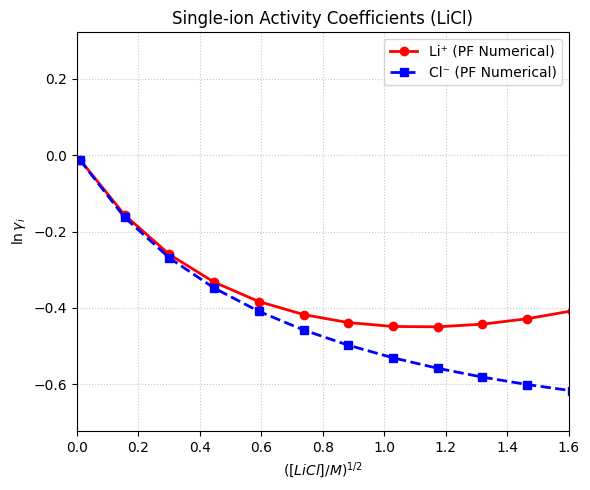

In [68]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt

# ==========================================
# 1. Physical Constants & Parameters
# ==========================================
T = 298.15
eps_w = 78.45
eps_0 = 8.854187e-12
e = 1.6021766e-19
kB = 1.380649e-23
NA = 6.02214e23

eps_s = eps_w * eps_0
l_B = e**2 / (4 * np.pi * eps_s * kB * T)
l_B_A = l_B * 1e10  # Bjerrum length in Angstroms (~7.14 A)

# Atomic radii (Angstroms)
a_Li = 0.6
a_Cl = 1.81
a_w = 1.4

# Hydration shell radii (Approx 1 water layer)
# The solver domain starts here!
R_sh_Li = a_Li + 2 * a_w
R_sh_Cl = a_Cl + 2 * a_w

# Volumes (Angstroms^3)
v_Li = (4/3) * np.pi * a_Li**3
v_Cl = (4/3) * np.pi * a_Cl**3
v_w = (4/3) * np.pi * a_w**3
v_0 = (v_Li + v_Cl + v_w) / 3.0  # Average volume

# Bulk water concentration (Molarity of pure water)
c_w_B_M = 55.5

# Born cavity radii at infinite dilution (Angstroms)
R0_Li = 1.3
R0_Cl = 2.266

# Fitting parameters for Born shift (Table I)
alpha_Li = np.array([-0.006, -0.037, 0.004])
alpha_Cl = np.array([0.052, -0.015, 0.0])

def get_born_shift(c_bulk_M, alpha, R0):
    """ Concentration-dependent Born energy shift (kBT) """
    theta = 1.0 + alpha[0]*np.sqrt(c_bulk_M) + alpha[1]*c_bulk_M + alpha[2]*(c_bulk_M**1.5)
    R_born = theta * R0
    return 0.5 * l_B_A * (1.0 / R_born - 1.0 / R0)

# ==========================================
# 2. Poisson-Fermi BVP Solver
# ==========================================
def solve_gamma(c_bulk_M, is_cation=True):
    c_bulk_m3 = c_bulk_M * 1000 * NA
    l_D_A = (1.0 / np.sqrt(2 * c_bulk_m3 * e**2 / (eps_s * kB * T))) * 1e10

    # Bulk volume fractions
    Phi_Li_B = v_Li * c_bulk_M * 1000 * NA * 1e-30
    Phi_Cl_B = v_Cl * c_bulk_M * 1000 * NA * 1e-30
    Phi_w_B  = v_w * c_w_B_M * 1000 * NA * 1e-30
    Gamma_B = 1.0 - (Phi_Li_B + Phi_Cl_B + Phi_w_B)

    R_sh = R_sh_Li if is_cation else R_sh_Cl
    z_center = 1.0 if is_cation else -1.0

    # Dimensionless domain
    x_min = R_sh / l_D_A
    x_max = 15.0  # Integrate out to 15 Debye lengths

    # Boundary condition: electric field at the hydration shell
    dy_dx_surface = - (z_center * l_B_A * l_D_A) / (R_sh**2)

    def calc_gamma_r(y):
        """ Iteratively solve the non-linear local void fraction """
        G_ratio = np.ones_like(y)
        for _ in range(4):
            C_Li_f = np.exp(-1.0 * y) * (G_ratio ** (v_Li / v_0))
            C_Cl_f = np.exp( 1.0 * y) * (G_ratio ** (v_Cl / v_0))
            C_w_f  = (G_ratio ** (v_w / v_0))
            Gamma_r = 1.0 - (Phi_Li_B * C_Li_f + Phi_Cl_B * C_Cl_f + Phi_w_B * C_w_f)
            Gamma_r = np.maximum(Gamma_r, 1e-6)
            G_ratio = Gamma_r / Gamma_B
        return G_ratio

    def bvp_system(x, Y):
        y, dy = Y[0], Y[1]
        G_ratio = calc_gamma_r(y)

        # Local dimensionless concentrations with asymmetric steric exponents
        c_hat_Li = np.exp(-1.0 * y) * (G_ratio ** (v_Li / v_0))
        c_hat_Cl = np.exp( 1.0 * y) * (G_ratio ** (v_Cl / v_0))

        charge_density = 0.5 * (c_hat_Cl - c_hat_Li)
        return np.vstack((dy, - (2.0 / x) * dy + charge_density))

    def boundary_conditions(Ya, Yb):
        return np.array([Ya[1] - dy_dx_surface, Yb[0]])

    # Debye-Huckel guess to initialize the solver safely
    x_mesh = np.logspace(np.log10(x_min), np.log10(x_max), 400)
    y_surf_guess = -dy_dx_surface * x_min / (1.0 + x_min)
    y_guess = y_surf_guess * (x_min / x_mesh) * np.exp(-(x_mesh - x_min))

    sol = solve_bvp(bvp_system, boundary_conditions, x_mesh,
                    np.vstack((y_guess, np.zeros_like(x_mesh))), tol=1e-3)

    if not sol.success: return np.nan

    # Reaction potential at the shell boundary
    y_surface = sol.y[0][0]
    y_bare = z_center * l_B_A / R_sh
    y_reaction = y_surface - y_bare

    # Add the Born shift [cite: 149-150]
    alpha = alpha_Li if is_cation else alpha_Cl
    R0 = R0_Li if is_cation else R0_Cl
    born_shift = get_born_shift(c_bulk_M, alpha, R0)

    return 0.5 * z_center * y_reaction + born_shift

# ==========================================
# 3. Execution & Plotting
# ==========================================
# Sweep concentrations up to ~2.56 M to match the paper's x-axis limit of 1.6
sqrt_c = np.linspace(0.01, 3.5, 25)
conc_M = sqrt_c**2

ln_g_Li = np.zeros_like(conc_M)
ln_g_Cl = np.zeros_like(conc_M)

print("Running Poisson-Fermi solver...")
for i, c in enumerate(conc_M):
    ln_g_Li[i] = solve_gamma(c, is_cation=True)
    ln_g_Cl[i] = solve_gamma(c, is_cation=False)

fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(sqrt_c, ln_g_Li, 'ro-', linewidth=2, label='Li⁺ (PF Numerical)')
ax.plot(sqrt_c, ln_g_Cl, 'bs--', linewidth=2, label='Cl⁻ (PF Numerical)')

ax.set_xlabel('$([LiCl]/M)^{1/2}$')
ax.set_ylabel('$\ln \gamma_i$')
ax.set_title('Single-ion Activity Coefficients (LiCl)')
ax.grid(True, linestyle=':', alpha=0.7)
ax.legend()
ax.set_xlim(0, 1.6)

plt.tight_layout()
plt.show()